# Free-Fermion Volume Benchmark – Tutorial

This notebook shows how to:
1. Construct a **FreeFermionBenchmark** from the `scalable_volumetric_benchmark` package.
2. Generate benchmark circuits
3. Attach results
4. Evaluate the experimental results

In [1]:
from ScalableVolumetricBenchmark import FreeFermionVolumeBenchmark

## Create benchmark

A benchmark instance can be created simply by defining the required parameters for running a benchmark experiment and initializing the benchmark object.

In [2]:
n_qubits = 5
sample_size = 10
shots = 2048

benchmark = FreeFermionVolumeBenchmark(
    number_of_qubits=n_qubits,
    sample_size=sample_size,
    format="qasm2",
    target_sdk="qiskit",
    shots=shots,
    benchmark_metadata = {'type':'Free-fermion volume', 'descripton' : 'Example of a benchamrk Free-fermion Volueme benchmark protocol '},
    auto_save=False,
    workdir="tutorial_data",
)

You can then generate the benchmark circuits by calling the corresponding method.

In [3]:
benchmark.create_benchmark()

benchmark # print the main properties of the benchmark instnce 

FreeFermionVolumeBenchmark(
  benchmark_id='free_fermion_nq5_s10_20260129T125943_53126819',
  number_of_qubits=5,
  sample_size=10,
  format='qasm2',
  target_sdk='qiskit',
  workdir=WindowsPath('tutorial_data'),
)

You can easily access any of the characteristics of the benchmark protocol or the corresponding circuits, such as:
- the ID of the benchmark (`benchmark.benchmark_id`)
- benchmark metadata (`benchmark.benchmark_metadata`)
- default directory used to save the benchmark instance (`benchmark.DEFAULT_WORKDIR`)
- emitter options used to generate circuits (`benchmark.emitter_options`)
- circuit representation format (`benchmark.format`)
- number of measurement schemes per sample (`benchmark.number_of_measurements`)
- number of qubits used in the benchmark (`benchmark.number_of_qubits`)
- number of samples in the benchmark (`benchmark.sample_size`)
- target SDK used for circuit generation (`benchmark.target_sdk`)
- etc.


In [4]:
print("benchmark.benchmark_id:", benchmark.benchmark_id)
print("benchmark.benchmark_metadata:", benchmark.benchmark_metadata)
print("benchmark.DEFAULT_WORKDIR:", benchmark.DEFAULT_WORKDIR)
print("benchmark.emitter_options:", benchmark.emitter_options)
print("benchmark.format:", benchmark.format)
print("benchmark.number_of_measurements:", benchmark.number_of_measurements)
print("benchmark.number_of_qubits:", benchmark.number_of_qubits)
print("benchmark.sample_size:", benchmark.sample_size)
print("benchmark.target_sdk:", benchmark.target_sdk)

benchmark.benchmark_id: free_fermion_nq5_s10_20260129T125943_53126819
benchmark.benchmark_metadata: {'type': 'Free-fermion volume', 'descripton': 'Example of a benchamrk Free-fermion Volueme benchmark protocol '}
benchmark.DEFAULT_WORKDIR: .benchmarks
benchmark.emitter_options: QasmEmitterOptions(format='qasm2', target_sdk='qiskit', includes=('qelib1.inc',), float_precision=6, custom_template=None, map={'x': 'x', 'y': 'y', 'z': 'z', 'h': 'h', 's': 's', 'sdg': 'sdg', 't': 't', 'u': 'u3', 'cx': 'cx', 'cy': 'cy', 'cz': 'cz', 'swap': 'swap', 'rx': 'rx', 'ry': 'ry', 'rz': 'rz', 'measure': 'measure'})
benchmark.format: qasm2
benchmark.number_of_measurements: 10
benchmark.number_of_qubits: 5
benchmark.sample_size: 10
benchmark.target_sdk: qiskit


---

You can retrieve the generated samples as a collection of all benchmark circuits for a given experiment. Each sample represents a single logical unitary (or base circuit), while multiple measurement configurations of that unitary are stored as separate concrete circuits within the same sample.

`benchmark.samples` is a list of samples, where each sample corresponds to one complete experiment. In typical benchmarking protocols, the same type of experiment is repeated multiple times; therefore, this list usually contains many samples of the same benchmark type.

Each sample is represented as a dictionary containing:
- `sample_id`: a unique identifier for the sample.
- `sample_metadata`: metadata associated with the sample (for example, its type or description).
- `circuits`: a list of concrete circuits corresponding to different measurement configurations.

The `sample_metadata` field is a structured dictionary that contains the following entries:
- `type`
- `orthogonal_matrix`: hte SO(2n) matrix representing the free-fermion operator associated with the sample.
- `initial_state_index`: the index of the qubit that is prepared in to the x-basis state 
- `number_of_measurements`: the number of measurement configurations associated with the sample.

Each element of `circuits` is itself a dictionary with the following fields:
- `circuit_id`: a unique identifier for the circuit.
- `observable`: the Pauli operator defining the measurement setting.
- `qasm`: the QASM code for the corresponding quantum circuit.
- `metadata`: optional circuit-level metadata describing the role or type of the circuit.

Together, the entries in `circuits` contain all concrete circuits that constitute a single experimental sample.


In [5]:
# Print properties of the first sample
sample = benchmark.samples[0]

print("sample_id:", sample.get("sample_id"))

print("\nSmaple metadata:\n")
print("type:", sample.get("sample_metadata").get("type"))
print("number_of_measurements:", sample.get("sample_metadata").get("number_of_measurements"))
print("index of the initial state:", sample.get("sample_metadata").get("initial_state_index"))
print("SO matrix:\n", sample.get("sample_metadata").get("orthogonal_matrix"))

print("\ncircuits:\n")
circuits = sample.get("circuits", [])

#print the first circuit

circuit = circuits[0]

print("circuit_id:", circuit.get("circuit_id"))
print("observable:", circuit.get("observable"))
print("qasm:\n", circuit.get("qasm"))
print("metadata:", circuit.get("metadata"))


sample_id: 0

Smaple metadata:

type: free_fermion
number_of_measurements: 10
index of the initial state: 8
SO matrix:
 [[ 0.20736434 -0.37334441 -0.24232537 -0.04396438  0.23239257  0.77653551
  -0.09798336  0.23356407  0.11351252  0.15135329]
 [ 0.4693659  -0.69268744  0.1321495   0.32700325 -0.12192035 -0.26883732
   0.22366389 -0.13558129 -0.13981492 -0.01977457]
 [-0.00742211  0.07038185 -0.63196894  0.34361997 -0.17413351  0.09375152
  -0.08176284 -0.25635498  0.0076725  -0.60494475]
 [ 0.15246693 -0.15433849 -0.39660501 -0.30452382  0.45351797 -0.52848852
  -0.14308682  0.33185274  0.27477602 -0.10873166]
 [-0.27892154 -0.1733166   0.03647131  0.32530197  0.2787931  -0.10107313
  -0.70340066 -0.05880832 -0.4203984   0.14867922]
 [ 0.02862571  0.06744477 -0.39845542 -0.28562762  0.09755595 -0.0152674
   0.35766844 -0.03137779 -0.76216401  0.1863502 ]
 [ 0.17911841  0.17481145  0.41069676  0.06190215  0.61266094  0.14370025
   0.16113256 -0.00808064 -0.1988691  -0.55070205]
 [ 0.2

 ---

One can easily retrieve all `circuit_id`s from a benchmark protocol by calling the `benchmark.get_all_circuit_ids()` method. Similarly, all benchmark circuits across all samples can be retrieved as a list by calling `benchmark.get_all_circuits()`.

In practice, these methods make it easier to execute large batches of circuits.

In [6]:
print(benchmark.get_all_circuit_ids())
print("\n")
circuits = benchmark.get_all_circuits()
print(circuits[0]) # print the first circuit

['0_maj_0', '0_maj_1', '0_maj_2', '0_maj_3', '0_maj_4', '0_maj_5', '0_maj_6', '0_maj_7', '0_maj_8', '0_maj_9', '1_maj_0', '1_maj_1', '1_maj_2', '1_maj_3', '1_maj_4', '1_maj_5', '1_maj_6', '1_maj_7', '1_maj_8', '1_maj_9', '2_maj_0', '2_maj_1', '2_maj_2', '2_maj_3', '2_maj_4', '2_maj_5', '2_maj_6', '2_maj_7', '2_maj_8', '2_maj_9', '3_maj_0', '3_maj_1', '3_maj_2', '3_maj_3', '3_maj_4', '3_maj_5', '3_maj_6', '3_maj_7', '3_maj_8', '3_maj_9', '4_maj_0', '4_maj_1', '4_maj_2', '4_maj_3', '4_maj_4', '4_maj_5', '4_maj_6', '4_maj_7', '4_maj_8', '4_maj_9', '5_maj_0', '5_maj_1', '5_maj_2', '5_maj_3', '5_maj_4', '5_maj_5', '5_maj_6', '5_maj_7', '5_maj_8', '5_maj_9', '6_maj_0', '6_maj_1', '6_maj_2', '6_maj_3', '6_maj_4', '6_maj_5', '6_maj_6', '6_maj_7', '6_maj_8', '6_maj_9', '7_maj_0', '7_maj_1', '7_maj_2', '7_maj_3', '7_maj_4', '7_maj_5', '7_maj_6', '7_maj_7', '7_maj_8', '7_maj_9', '8_maj_0', '8_maj_1', '8_maj_2', '8_maj_3', '8_maj_4', '8_maj_5', '8_maj_6', '8_maj_7', '8_maj_8', '8_maj_9', '9_maj_0'

---

Now let us load some experimental results obtained from a simulated backend.   The `clifford_benchmark_results.json` file contains a dictionary of results, where the keys correspond to the `circuit_id`s.


In [7]:
import json

with open("tutorial_data/free_fermion_benchmark_results.json", "r", encoding="utf-8") as f:
    data = json.load(f)


---

## Attach experimental results

The benchmark can be initialized from a previously saved JSON file. The file must follow the JSON schema defined as part of this project. (We will load a previously saved benchmark instance to ensure that the results shown in this example correspond to this benchmark.)

In [8]:
benchmark = FreeFermionVolumeBenchmark.load_json(r'tutorial_data/free_fermion_nq5_s10_20260129T124307_03ae1188.json')

One can simply attach the experimental data to the benchmark instance by calling the corresponding `benchmark.add_experimental_results()` method. This method provides options to define useful parameters that are stored together with the data, such as an `experiment_id` to identify the given experimental run, a `platform` field to indicate where the results were obtained from, and an `experiment_metadata` dictionary containing any additional information relevant to the experiment. If the `auto_save` variable of the object is set to `True`, any changes to the object—such as adding experimental results—will be immediately saved to the local file under the working directory.


In [9]:
benchmark.add_experimental_results(
    data,
    experiment_id="qiskit_aer_free_fermion_demo",
    platform="qiskit-aer",
    experiment_metadata={"backend": "AerSimulator"},
)


[Benchmark] Saved to: tutorial_data\free_fermion_nq5_s10_20260129T124307_03ae1188.json


Later, all experimental data can be retrieved directly from the benchmark object via the `benchmark.experimental_results` attribute. The raw measurement counts obtained from the experiment can be accessed using `benchmark.experimental_results["results"]`.


In [10]:
print('experiment_id:', benchmark.experimental_results['experiment_id'])
print('experiment_metadata:', benchmark.experimental_results['experiment_metadata'])
print('platform:', benchmark.experimental_results['platform'])

experiment_id: qiskit_aer_free_fermion_demo
experiment_metadata: {'backend': 'AerSimulator'}
platform: qiskit-aer


In [11]:
benchmark.experimental_results['results'] # data for the first circuit

{'0_maj_0': {'counts': {'10100': 223,
   '01110': 72,
   '01010': 21,
   '10000': 267,
   '10010': 88,
   '10001': 229,
   '00000': 69,
   '01101': 140,
   '11100': 83,
   '10110': 161,
   '00001': 12,
   '00100': 62,
   '10111': 50,
   '01100': 166,
   '00101': 34,
   '11101': 76,
   '11111': 11,
   '10101': 33,
   '00111': 4,
   '00110': 53,
   '01011': 3,
   '11110': 35,
   '11000': 27,
   '10011': 11,
   '01000': 14,
   '00011': 2,
   '01001': 49,
   '01111': 23,
   '00010': 15,
   '11001': 7,
   '11011': 6,
   '11010': 2}},
 '0_maj_1': {'counts': {'01000': 46,
   '11000': 255,
   '11101': 137,
   '11110': 226,
   '00101': 83,
   '10100': 402,
   '00001': 25,
   '10000': 52,
   '01111': 36,
   '10101': 57,
   '11111': 33,
   '10001': 130,
   '01110': 25,
   '11010': 11,
   '11100': 42,
   '00111': 10,
   '01100': 69,
   '01010': 21,
   '10010': 77,
   '00100': 23,
   '00000': 22,
   '11001': 41,
   '01101': 17,
   '01001': 101,
   '10011': 9,
   '00110': 51,
   '10111': 16,
   '000

Since all changes are saved to the benchmark JSON file, the entire protocol - together with the experimental results - can be reinitialized by loading the file via the `.load_josn(...)` method.


In [12]:
FreeFermionVolumeBenchmark.load_json(r'tutorial_data/free_fermion_nq5_s10_20260129T124307_03ae1188.json')

FreeFermionVolumeBenchmark(
  benchmark_id='free_fermion_nq5_s10_20260129T124307_03ae1188',
  number_of_qubits=5,
  sample_size=10,
  format='qasm2',
  target_sdk='qiskit',
  workdir=WindowsPath('tutorial_data'),
)

---

## Evaluate benchmark

The benchmark can be evaluated by calling the `benchmark.evaluate_benchmark()` method. This method runs the implemented evaluation routines to compute the relevant quantities from the experimental results. These quantities typically include collections of expectation values and derived metrics used to assess the performance of the benchmark.

The evaluation method prints a short summary of the results and returns all computed combination of the expectation values. The results are also stored in the benchmark object and saved to the JSON file if the `auto_save` option is set to `True`.

In [13]:
evaluation = benchmark.evaluate_benchmark()


 Free-Fermion Benchmark Evaluation (5 qubits)

Parallel projected values (should be near 1):
  • average: 0.994133 ± 0.019398
  • lowest measured value: 0.968483

Orthogonal projected values (should be near 0):
  • average: -0.002077 ± 0.018067
  • highest absolute value: 0.034546


Benchmark passed: True

[Benchmark] Saved updated JSON to: tutorial_data\free_fermion_nq5_s10_20260129T124307_03ae1188.json


All data produced by the evaluation are stored in the `benchmark.experimental_results['evaluation']` attribute of the benchmark object and can be accessed using the corresponding keys.

In [14]:
parallel_values = benchmark.experimental_results['evaluation']['parallel_values'] # all "parallel" combinations
orthogonal_values = benchmark.experimental_results['evaluation']['orthogonal_values'] # and the "orthogonal" combination

The user can access the computed expectation values for all observables as a structured dictionary—organized by sample and by operator—by calling the `benchmark.get_all_expectation_values()` method.

Besides the built-in evaluation functions, one can choose to manually evaluate the experimental results for any of the executed circuits. For this purpose, the `Benchmark.expected_value()` method can be used. It takes the measurement counts and the corresponding operator as input. Optionally, the ordering of the bits in the count dictionary can be specified, allowing the expectation value to be computed correctly for a given experiment.

In [15]:
i = 2
j = 1

result = benchmark.experimental_results['results'][f'{j}_maj_{i}'] # get the result for the ith circuit in the jth sample
count = result.get('counts') # get the counts from the results
puali = benchmark.samples[j]['circuits'][i]['observable']

print(benchmark.samples[j]['circuits'][i]['metadata']['kind'])
print(benchmark.expected_value(counts=count, pauli=benchmark.samples[j]['circuits'][i]['observable']))


majorana
0.40625


## Plot evaluation

One can use the built-in `benchmark.plot_all_expectation_values() function to plot the calculated expectation values.


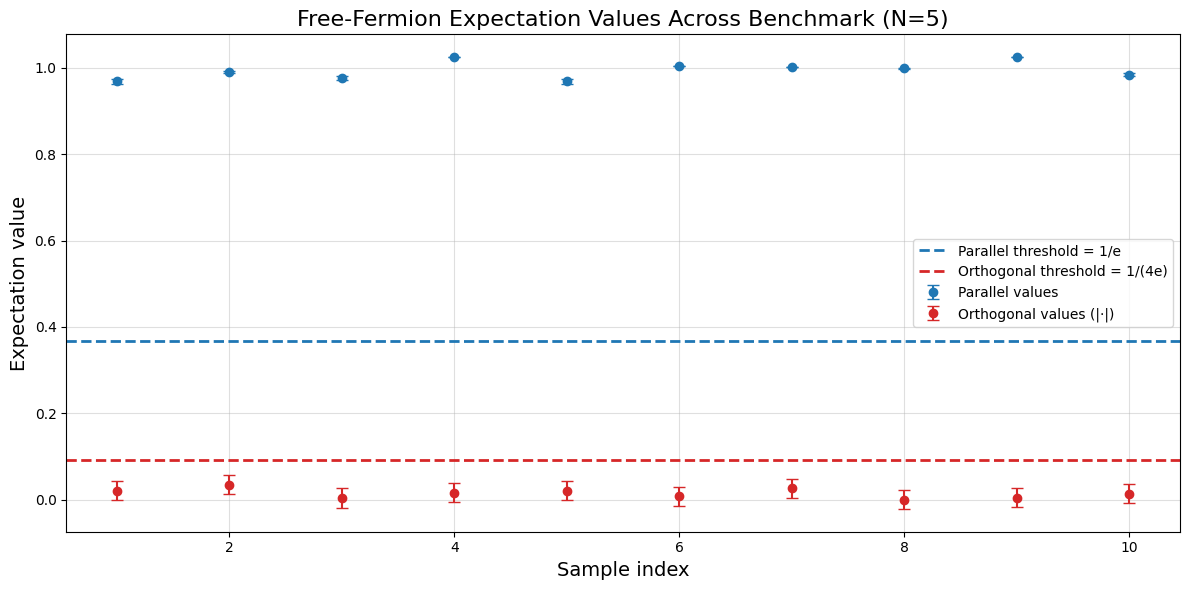

In [16]:
benchmark.plot_all_expectation_values()


Or the `benchmark.plot_expectation_histograms(bins=5)` funtion to plut the distribution of the expeaction values.

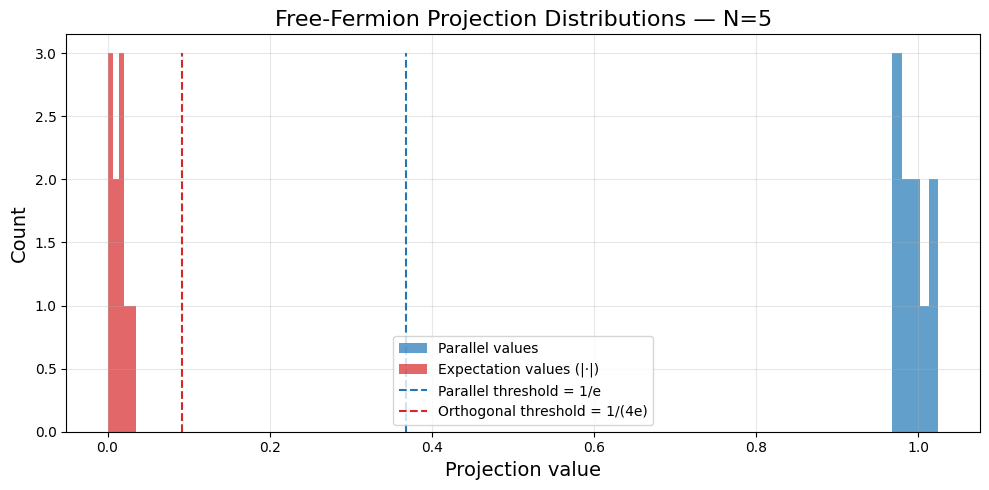

In [17]:
benchmark.plot_expectation_histograms(bins=5)